In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2

In [50]:
df = pd.read_csv('tedsd_puf_2019.csv')
df.head()

,DISYR,CASEID,STFIPS,CBSA2010,EDUC,MARSTAT,SERVICES,DETCRIM,LOS,PSOURCE,...,TRNQFLG,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG
0,2019,20191553576,2,-9,4,1,7,-9,37,1,...,0,0,0,0,0,0,9,4,0,1
1,2019,20191465214,2,-9,3,1,7,-9,35,1,...,0,0,0,0,0,0,9,4,0,3
2,2019,20191443889,2,-9,2,1,7,-9,35,1,...,0,0,0,0,0,0,9,4,0,3
3,2019,20191409377,2,-9,3,1,7,-9,37,1,...,0,0,0,0,0,0,9,4,0,3
4,2019,20191479567,2,-9,3,3,7,-9,37,1,...,0,0,0,0,0,0,9,4,0,1


# Data Exploration and Preprocessing

In [51]:
df.shape

(1722503, 76)

In [52]:
df = df.drop(['DISYR', 'CASEID'], axis = 1)

In [53]:
#Filter for only REASON = 1 (treatment completed) or 2 (dropped off)
df = df[(df['REASON'] == 1) | (df['REASON'] == 2)].reset_index(drop = True)
df.shape

(1158539, 74)

In [54]:
#Change 'Reason' encoding: 0 = Dropped off, 1 = Completed
df['REASON'] = df['REASON'].replace(2, 0)
df['REASON'].value_counts()

1    725929
0    432610
Name: REASON, dtype: int64

In [55]:
#Change male data points' label of 'PREG' to 3:
df.loc[df['GENDER'] == 1, 'PREG'] = 3
#Change the 'invalid' label in 'DETNLF' and 'DETNLF_D' to new label 6 
df.loc[df['EMPLOY'] != 4, 'DETNLF'] = 6
df.loc[df['EMPLOY_D'] != 4, 'DETNLF_D'] = 6
df

,STFIPS,CBSA2010,EDUC,MARSTAT,SERVICES,DETCRIM,LOS,PSOURCE,NOPRIOR,ARRESTS,...,TRNQFLG,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG
0,2,-9,4,1,7,-9,37,1,0,0,...,0,0,0,0,0,0,9,4,0,1
1,2,-9,3,1,7,-9,37,1,1,0,...,0,0,0,0,0,0,9,4,0,3
2,2,-9,2,2,7,-9,35,1,0,1,...,0,0,0,0,0,0,9,4,0,3
3,2,-9,3,1,7,-9,34,1,1,0,...,0,0,0,0,0,0,9,4,0,1
4,2,-9,3,1,7,-9,36,1,0,0,...,0,0,0,0,0,0,9,4,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1158534,56,-9,1,4,7,-9,33,6,0,0,...,0,0,0,0,0,0,8,4,0,2
1158535,56,-9,4,2,7,-9,33,1,0,0,...,0,0,0,0,0,0,8,4,0,1
1158536,56,-9,3,3,7,1,13,7,0,0,...,0,0,0,0,0,0,8,4,0,2
1158537,56,-9,1,1,7,3,14,7,0,0,...,0,0,0,0,0,0,8,4,0,3


In [56]:
miss_val_row_ct = len(df[df[df == -9].count(axis=1) > 0])
print('Number of rows with at least one missing value: ', miss_val_row_ct)

Number of rows with at least one missing value:  1156127


In [57]:
#Find percentage of missing values per column
print('Relative frequency of missing values (-9) per column:')
coldroplst = []
nulldict = {}
for col in df.columns:
    if -9 in df[col].unique():
        nullfreq = df[col].value_counts(normalize = True)[-9]
    else:
        nullfreq = 0
    nulldict[col] = nullfreq
    print(col, '{:.2f}'.format(nullfreq))
    if nullfreq >= 0.5:
        coldroplst.append(col)

Relative frequency of missing values (-9) per column:
STFIPS 0.00
CBSA2010 0.43
EDUC 0.14
MARSTAT 0.25
SERVICES 0.00
DETCRIM 0.81
LOS 0.00
PSOURCE 0.10
NOPRIOR 0.10
ARRESTS 0.15
EMPLOY 0.12
METHUSE 0.12
PSYPROB 0.15
PREG 0.02
GENDER 0.00
VET 0.13
LIVARAG 0.14
DAYWAIT 0.51
SERVICES_D 0.00
REASON 0.00
EMPLOY_D 0.25
LIVARAG_D 0.28
ARRESTS_D 0.27
DSMCRIT 0.26
AGE 0.00
RACE 0.05
ETHNIC 0.04
DETNLF 0.04
DETNLF_D 0.01
PRIMINC 0.35
SUB1 0.08
SUB2 0.04
SUB3 0.12
SUB1_D 0.18
SUB2_D 0.09
SUB3_D 0.06
ROUTE1 0.11
ROUTE2 0.50
ROUTE3 0.81
FREQ1 0.14
FREQ2 0.50
FREQ3 0.82
FREQ1_D 0.39
FREQ2_D 0.73
FREQ3_D 0.87
FRSTUSE1 0.11
FRSTUSE2 0.52
FRSTUSE3 0.82
HLTHINS 0.47
PRIMPAY 0.56
FREQ_ATND_SELF_HELP 0.25
FREQ_ATND_SELF_HELP_D 0.28
ALCFLG 0.00
COKEFLG 0.00
MARFLG 0.00
HERFLG 0.00
METHFLG 0.00
OPSYNFLG 0.00
PCPFLG 0.00
HALLFLG 0.00
MTHAMFLG 0.00
AMPHFLG 0.00
STIMFLG 0.00
BENZFLG 0.00
TRNQFLG 0.00
BARBFLG 0.00
SEDHPFLG 0.00
INHFLG 0.00
OTCFLG 0.00
OTHERFLG 0.00
DIVISION 0.00
REGION 0.00
IDU 0.10
ALCDRUG 0.0

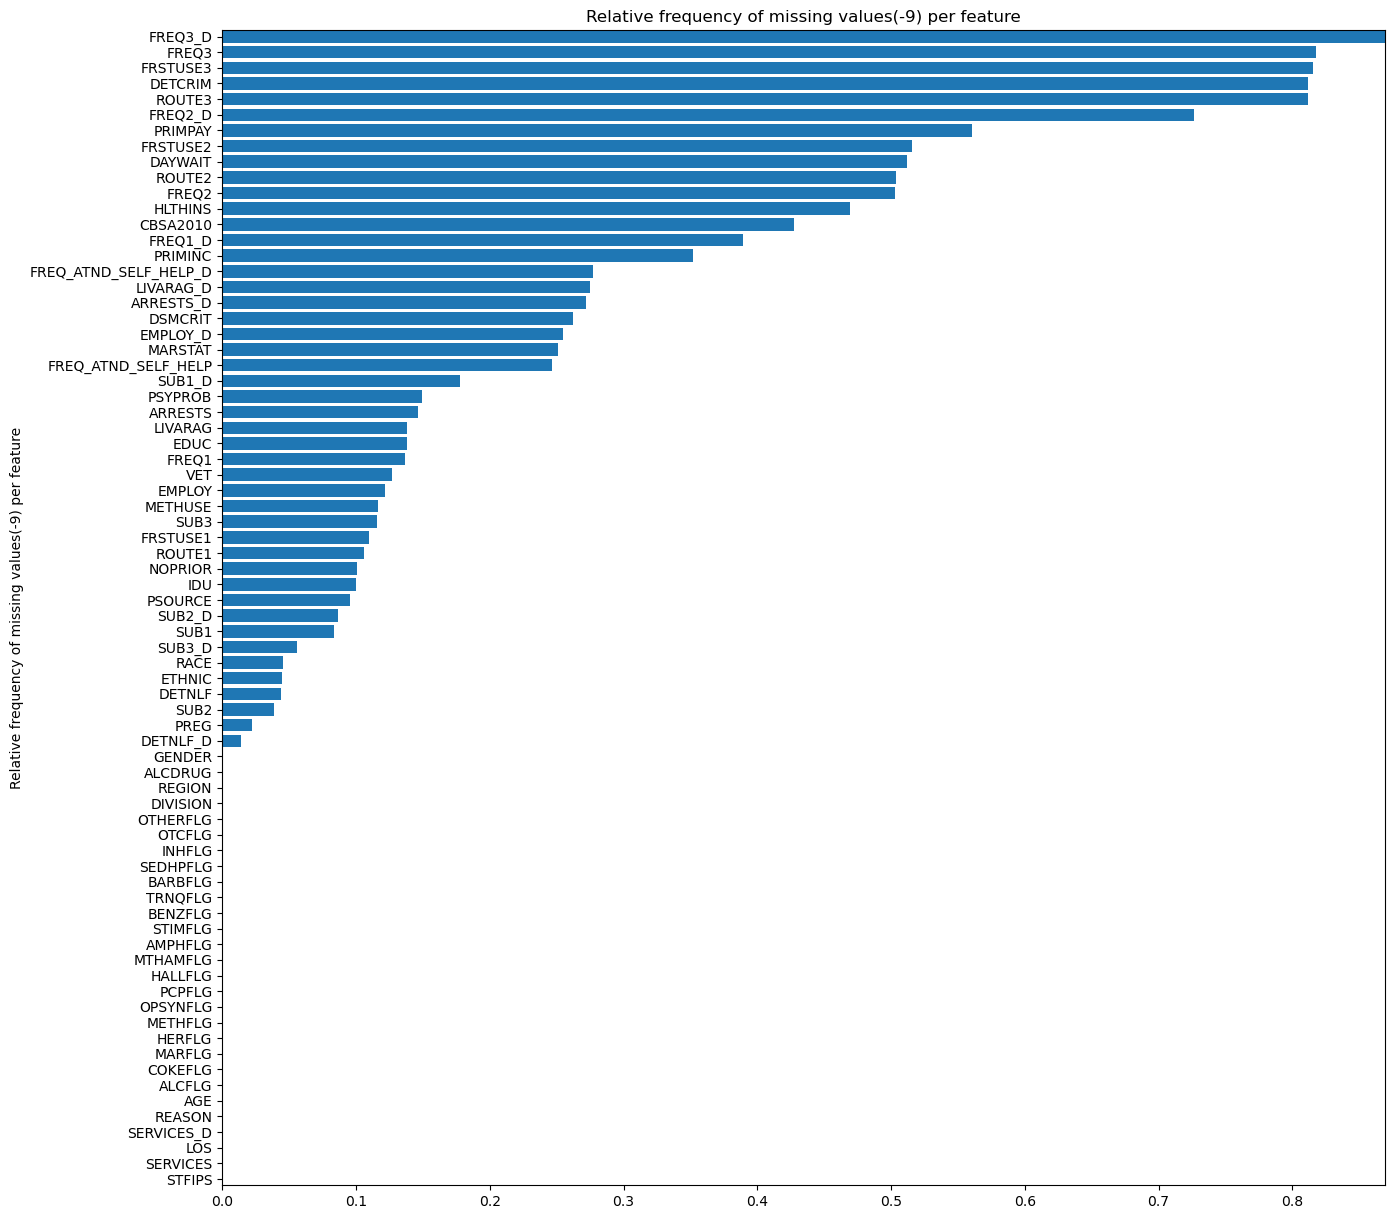

In [58]:
#Plot bar chart to visualize missing values frequency per feature
nulldict_sorted = {k: v for k, v in sorted(nulldict.items(), key=lambda item: item[1])}
fig = plt.figure(figsize = (15,15))
plt.barh(list(nulldict_sorted.keys()), list(nulldict_sorted.values()))
plt.ylabel('Relative frequency of missing values(-9) per feature')
plt.title('Relative frequency of missing values(-9) per feature')
plt.margins(0)
plt.show()

### Drop features with >= 50% missing values -> df1

In [59]:
# Drop features with >50% missing values => df1
print('Drop columns with relative frequency of missing values >= 0.5')
df1 = df.drop(coldroplst, axis = 1).reset_index(drop = True)
print('New df shape: ', df1.shape)
ct = len(df1[df1[df1 == -9].count(axis=1) > 0])
print('Number of rows with at least one missing value: ', ct)
df1

Drop columns with relative frequency of missing values >= 0.5
New df shape:  (1158539, 63)
Number of rows with at least one missing value:  1097914


,STFIPS,CBSA2010,EDUC,MARSTAT,SERVICES,LOS,PSOURCE,NOPRIOR,ARRESTS,EMPLOY,...,TRNQFLG,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG
0,2,-9,4,1,7,37,1,0,0,2,...,0,0,0,0,0,0,9,4,0,1
1,2,-9,3,1,7,37,1,1,0,3,...,0,0,0,0,0,0,9,4,0,3
2,2,-9,2,2,7,35,1,0,1,4,...,0,0,0,0,0,0,9,4,0,3
3,2,-9,3,1,7,34,1,1,0,1,...,0,0,0,0,0,0,9,4,0,1
4,2,-9,3,1,7,36,1,0,0,2,...,0,0,0,0,0,0,9,4,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1158534,56,-9,1,4,7,33,6,0,0,4,...,0,0,0,0,0,0,8,4,0,2
1158535,56,-9,4,2,7,33,1,0,0,1,...,0,0,0,0,0,0,8,4,0,1
1158536,56,-9,3,3,7,13,7,0,0,4,...,0,0,0,0,0,0,8,4,0,2
1158537,56,-9,1,1,7,14,7,0,0,4,...,0,0,0,0,0,0,8,4,0,3


### Drop rows with >= 20% missing values -> df2

In [60]:
#Drop rows with >= 20% missing values => df2
df2 = df1[df1[df1 == -9].count(axis = 1) < len(df1.axes[1])/5].reset_index(drop = True)
df2

,STFIPS,CBSA2010,EDUC,MARSTAT,SERVICES,LOS,PSOURCE,NOPRIOR,ARRESTS,EMPLOY,...,TRNQFLG,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG
0,2,-9,4,1,7,37,1,0,0,2,...,0,0,0,0,0,0,9,4,0,1
1,2,-9,3,1,7,37,1,1,0,3,...,0,0,0,0,0,0,9,4,0,3
2,2,-9,2,2,7,35,1,0,1,4,...,0,0,0,0,0,0,9,4,0,3
3,2,-9,3,1,7,34,1,1,0,1,...,0,0,0,0,0,0,9,4,0,1
4,2,-9,3,1,7,36,1,0,0,2,...,0,0,0,0,0,0,9,4,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013702,56,-9,1,4,7,33,6,0,0,4,...,0,0,0,0,0,0,8,4,0,2
1013703,56,-9,4,2,7,33,1,0,0,1,...,0,0,0,0,0,0,8,4,0,1
1013704,56,-9,3,3,7,13,7,0,0,4,...,0,0,0,0,0,0,8,4,0,2
1013705,56,-9,1,1,7,14,7,0,0,4,...,0,0,0,0,0,0,8,4,0,3


### Use df2 for analysis for now (dropped columns with >= 50% missing values, then dropped rows with >=20% missing values)

In [61]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013707 entries, 0 to 1013706
Data columns (total 63 columns):
 #   Column                 Non-Null Count    Dtype
---  ------                 --------------    -----
 0   STFIPS                 1013707 non-null  int64
 1   CBSA2010               1013707 non-null  int64
 2   EDUC                   1013707 non-null  int64
 3   MARSTAT                1013707 non-null  int64
 4   SERVICES               1013707 non-null  int64
 5   LOS                    1013707 non-null  int64
 6   PSOURCE                1013707 non-null  int64
 7   NOPRIOR                1013707 non-null  int64
 8   ARRESTS                1013707 non-null  int64
 9   EMPLOY                 1013707 non-null  int64
 10  METHUSE                1013707 non-null  int64
 11  PSYPROB                1013707 non-null  int64
 12  PREG                   1013707 non-null  int64
 13  GENDER                 1013707 non-null  int64
 14  VET                    1013707 non-null  int64
 15

# Drop the rows with missing values

In [62]:
#Detect the number of missing values in every column:
col_with_missing = []
for attribute in range(df2.shape[1]):
    missing_bool = df2.iloc[:,attribute]==-9
    column_name = df2.columns[attribute]
    #print('The number of missing value in',column_name,':',missing_bool.sum())
    if missing_bool.sum()!=0:
        col_with_missing.append(df2.columns[attribute])

In [63]:
#Remove the rows with missing value in it:
for i in range(len(col_with_missing)):
    df2 = df2.drop(df2[df2[col_with_missing[i]]==-9].index)

In [64]:
df2.rename(columns={'REASON':'DROP'},inplace=True)

# Correlated Features Removal

In [65]:
corr_matrix = df2.corr(method='spearman').abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features 
df2_uncorr = df2.drop(to_drop, axis=1)

print('Features dropped:', to_drop)

Features dropped: ['GENDER', 'SERVICES_D', 'EMPLOY_D', 'DETNLF', 'SUB1_D', 'SUB2_D', 'SUB3_D', 'REGION']


In [66]:
df2_uncorr.columns

Index(['STFIPS', 'CBSA2010', 'EDUC', 'MARSTAT', 'SERVICES', 'LOS', 'PSOURCE',
       'NOPRIOR', 'ARRESTS', 'EMPLOY', 'METHUSE', 'PSYPROB', 'PREG', 'VET',
       'LIVARAG', 'DROP', 'LIVARAG_D', 'ARRESTS_D', 'DSMCRIT', 'AGE', 'RACE',
       'ETHNIC', 'DETNLF_D', 'PRIMINC', 'SUB1', 'SUB2', 'SUB3', 'ROUTE1',
       'FREQ1', 'FREQ1_D', 'FRSTUSE1', 'HLTHINS', 'FREQ_ATND_SELF_HELP',
       'FREQ_ATND_SELF_HELP_D', 'ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG',
       'METHFLG', 'OPSYNFLG', 'PCPFLG', 'HALLFLG', 'MTHAMFLG', 'AMPHFLG',
       'STIMFLG', 'BENZFLG', 'TRNQFLG', 'BARBFLG', 'SEDHPFLG', 'INHFLG',
       'OTCFLG', 'OTHERFLG', 'DIVISION', 'IDU', 'ALCDRUG'],
      dtype='object')

# Chi-Square Feature Selection

In [67]:
#Define the dependent variable and independent variables 
Y=df2_uncorr['DROP']
X=df2_uncorr.drop(columns=['DROP','CBSA2010','STFIPS'])

In [68]:
#Calculate the p-value of each feature under the H0:
# 'a feature is independent of dependent variable "drop"', and H1:
# 'a feature is not independent of dependent variable "drop"'
chi_square=chi2(X,Y)
p_value = pd.Series(chi_square[1])
p_value.index = X.columns
print(p_value)

EDUC                      2.393079e-10
MARSTAT                   6.091240e-22
SERVICES                 2.961265e-152
LOS                      7.419174e-120
PSOURCE                   0.000000e+00
NOPRIOR                   3.388608e-07
ARRESTS                   5.630110e-05
EMPLOY                    1.703245e-07
METHUSE                   1.021130e-18
PSYPROB                   1.826378e-03
PREG                      6.327126e-18
VET                       4.205519e-01
LIVARAG                   6.385446e-36
LIVARAG_D                 6.461428e-19
ARRESTS_D                 2.653290e-35
DSMCRIT                  3.601733e-163
AGE                      2.325274e-145
RACE                      1.382002e-65
ETHNIC                    1.359293e-01
DETNLF_D                  8.267725e-04
PRIMINC                   4.397986e-07
SUB1                      0.000000e+00
SUB2                      7.204580e-07
SUB3                     5.618042e-168
ROUTE1                    0.000000e+00
FREQ1                    

In [69]:
#Select the ten lowest p-value features as our main features 
p_value_sorted = p_value.sort_values(ascending=True)[:10]
p_value_sorted

SUB1                      0.000000e+00
HERFLG                    0.000000e+00
ROUTE1                    0.000000e+00
PSOURCE                   0.000000e+00
ALCFLG                   2.002804e-236
FREQ_ATND_SELF_HELP_D    1.244436e-190
DIVISION                 9.752817e-183
SUB3                     5.618042e-168
DSMCRIT                  3.601733e-163
IDU                      1.568161e-157
dtype: float64

In [72]:
df_model=df2[['SUB1','HERFLG','ROUTE1','PSOURCE','ALCFLG',
    'FREQ_ATND_SELF_HELP_D','DIVISION','SUB3','DSMCRIT','IDU','DROP']]

In [73]:
df_model

,SUB1,HERFLG,ROUTE1,PSOURCE,ALCFLG,FREQ_ATND_SELF_HELP_D,DIVISION,SUB3,DSMCRIT,IDU,DROP
15,2,0,1,1,1,1,9,1,4,0,1
23,2,0,1,1,1,2,9,10,4,0,0
49,5,1,4,1,0,1,9,1,5,1,0
130,5,1,2,1,0,1,8,4,5,0,0
139,5,1,4,1,0,1,9,19,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1011924,10,1,2,7,0,5,8,1,8,0,0
1012245,10,0,3,7,0,5,8,1,8,0,1
1012537,2,0,1,7,1,5,8,1,3,0,0
1013341,4,0,2,7,0,1,8,1,10,0,0


In [74]:
#Save a new dataset with only main features left 
df_model.to_csv('data_after_preprocessing.csv',index=False)

# Appendix: Visualized Data Exploration

<AxesSubplot:title={'center':'Number of Unique Values per Feature'}>

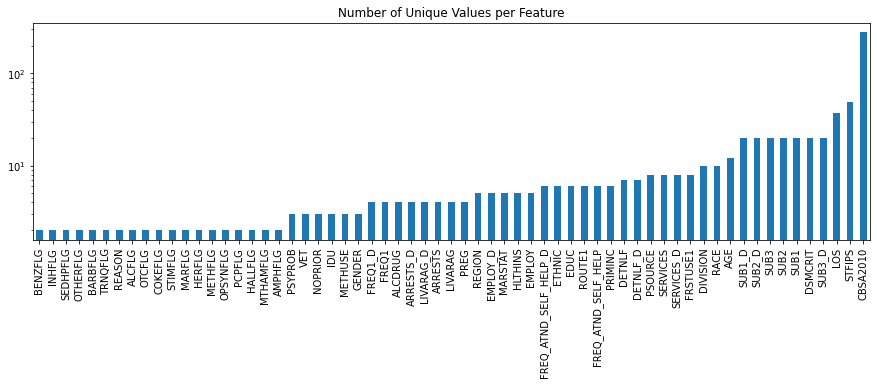

In [ ]:
# For each numerical feature compute number of unique entries
unique_values = df2.select_dtypes(include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Number of Unique Values per Feature")

Correlation heatmap:


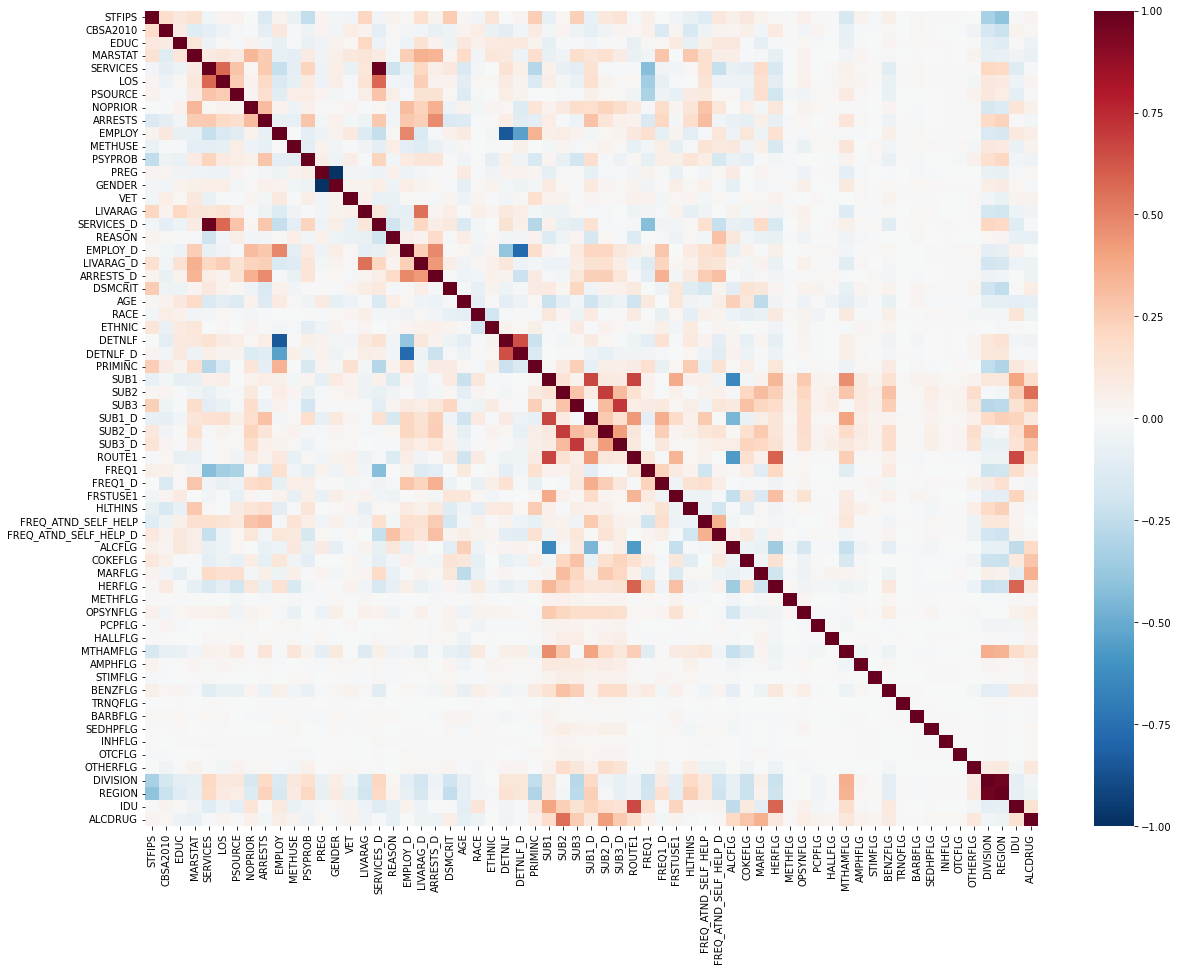

In [ ]:
print('Correlation heatmap:')
fig = plt.figure(figsize = (20,15))
ax = sns.heatmap(df2.corr(method = 'spearman'), cmap='RdBu_r', vmax=1, vmin=-1)
plt.show()

Data points per feature (x-axis is sample index, y-axis is feature value)


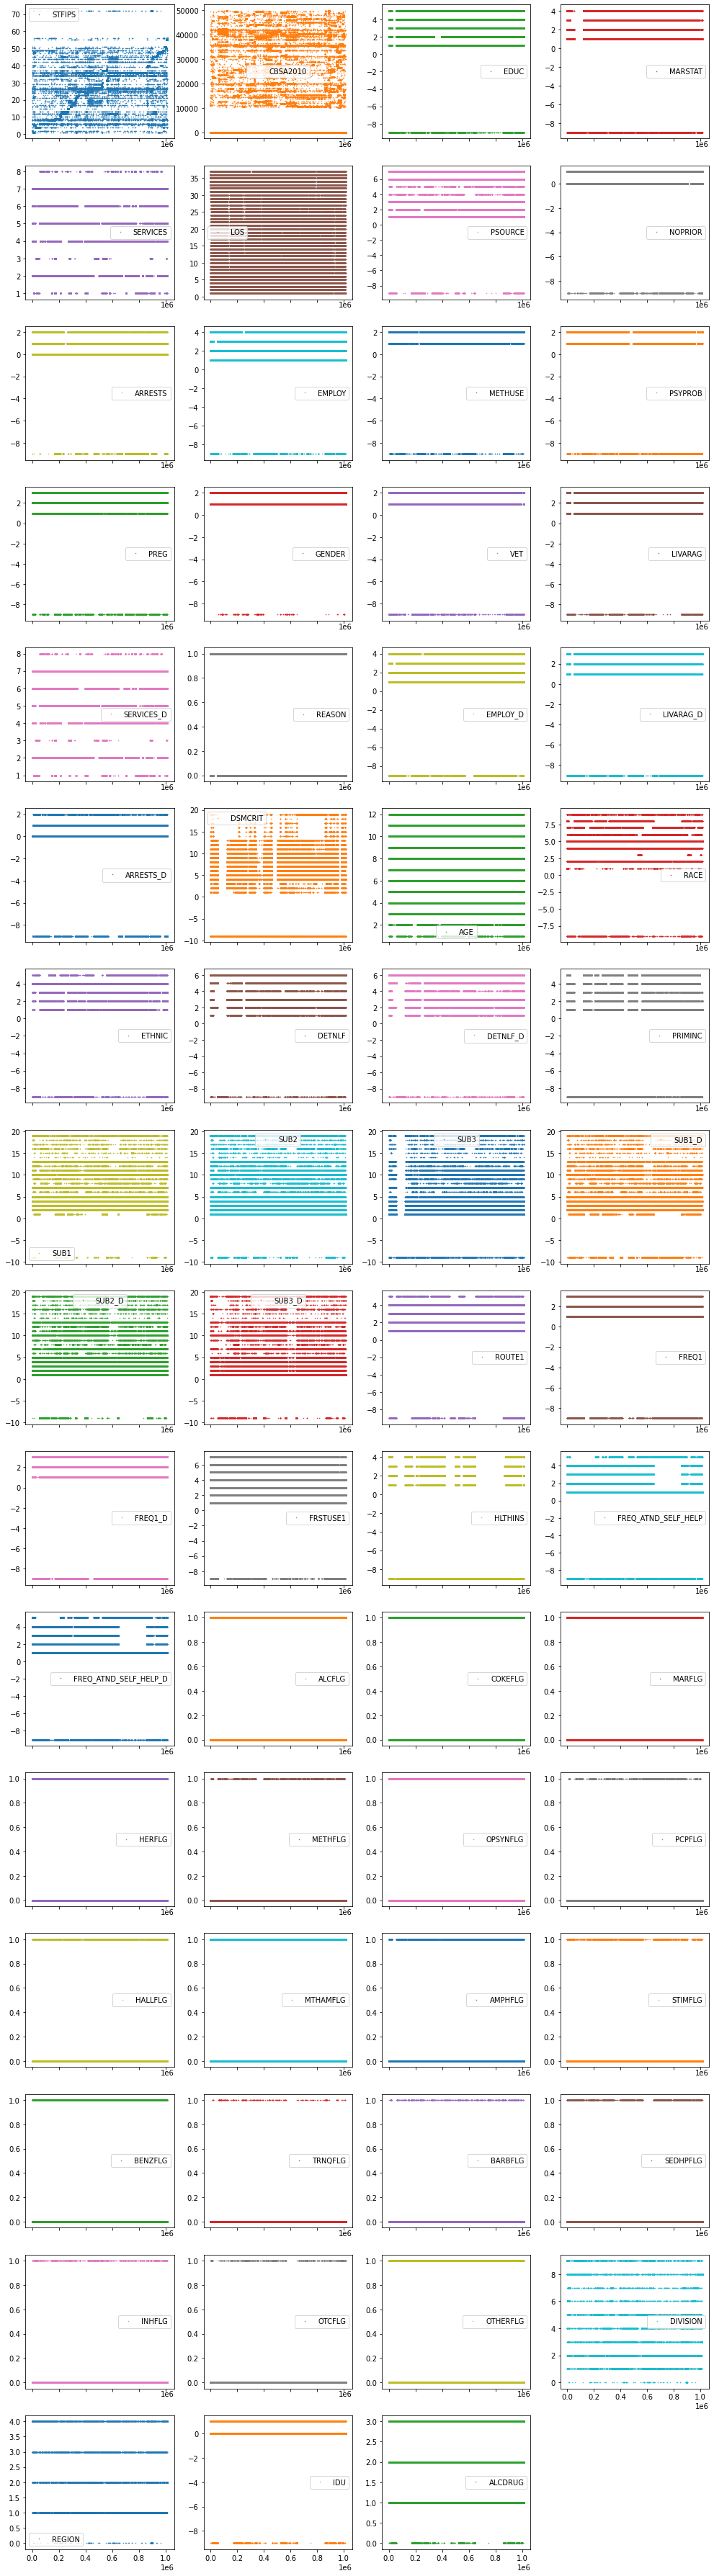

In [ ]:
#Plot all data points per feature
print('Data points per feature (x-axis is sample index, y-axis is feature value)')
df2.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
          figsize=(17, 65), markersize=1);

Histogram for each feature


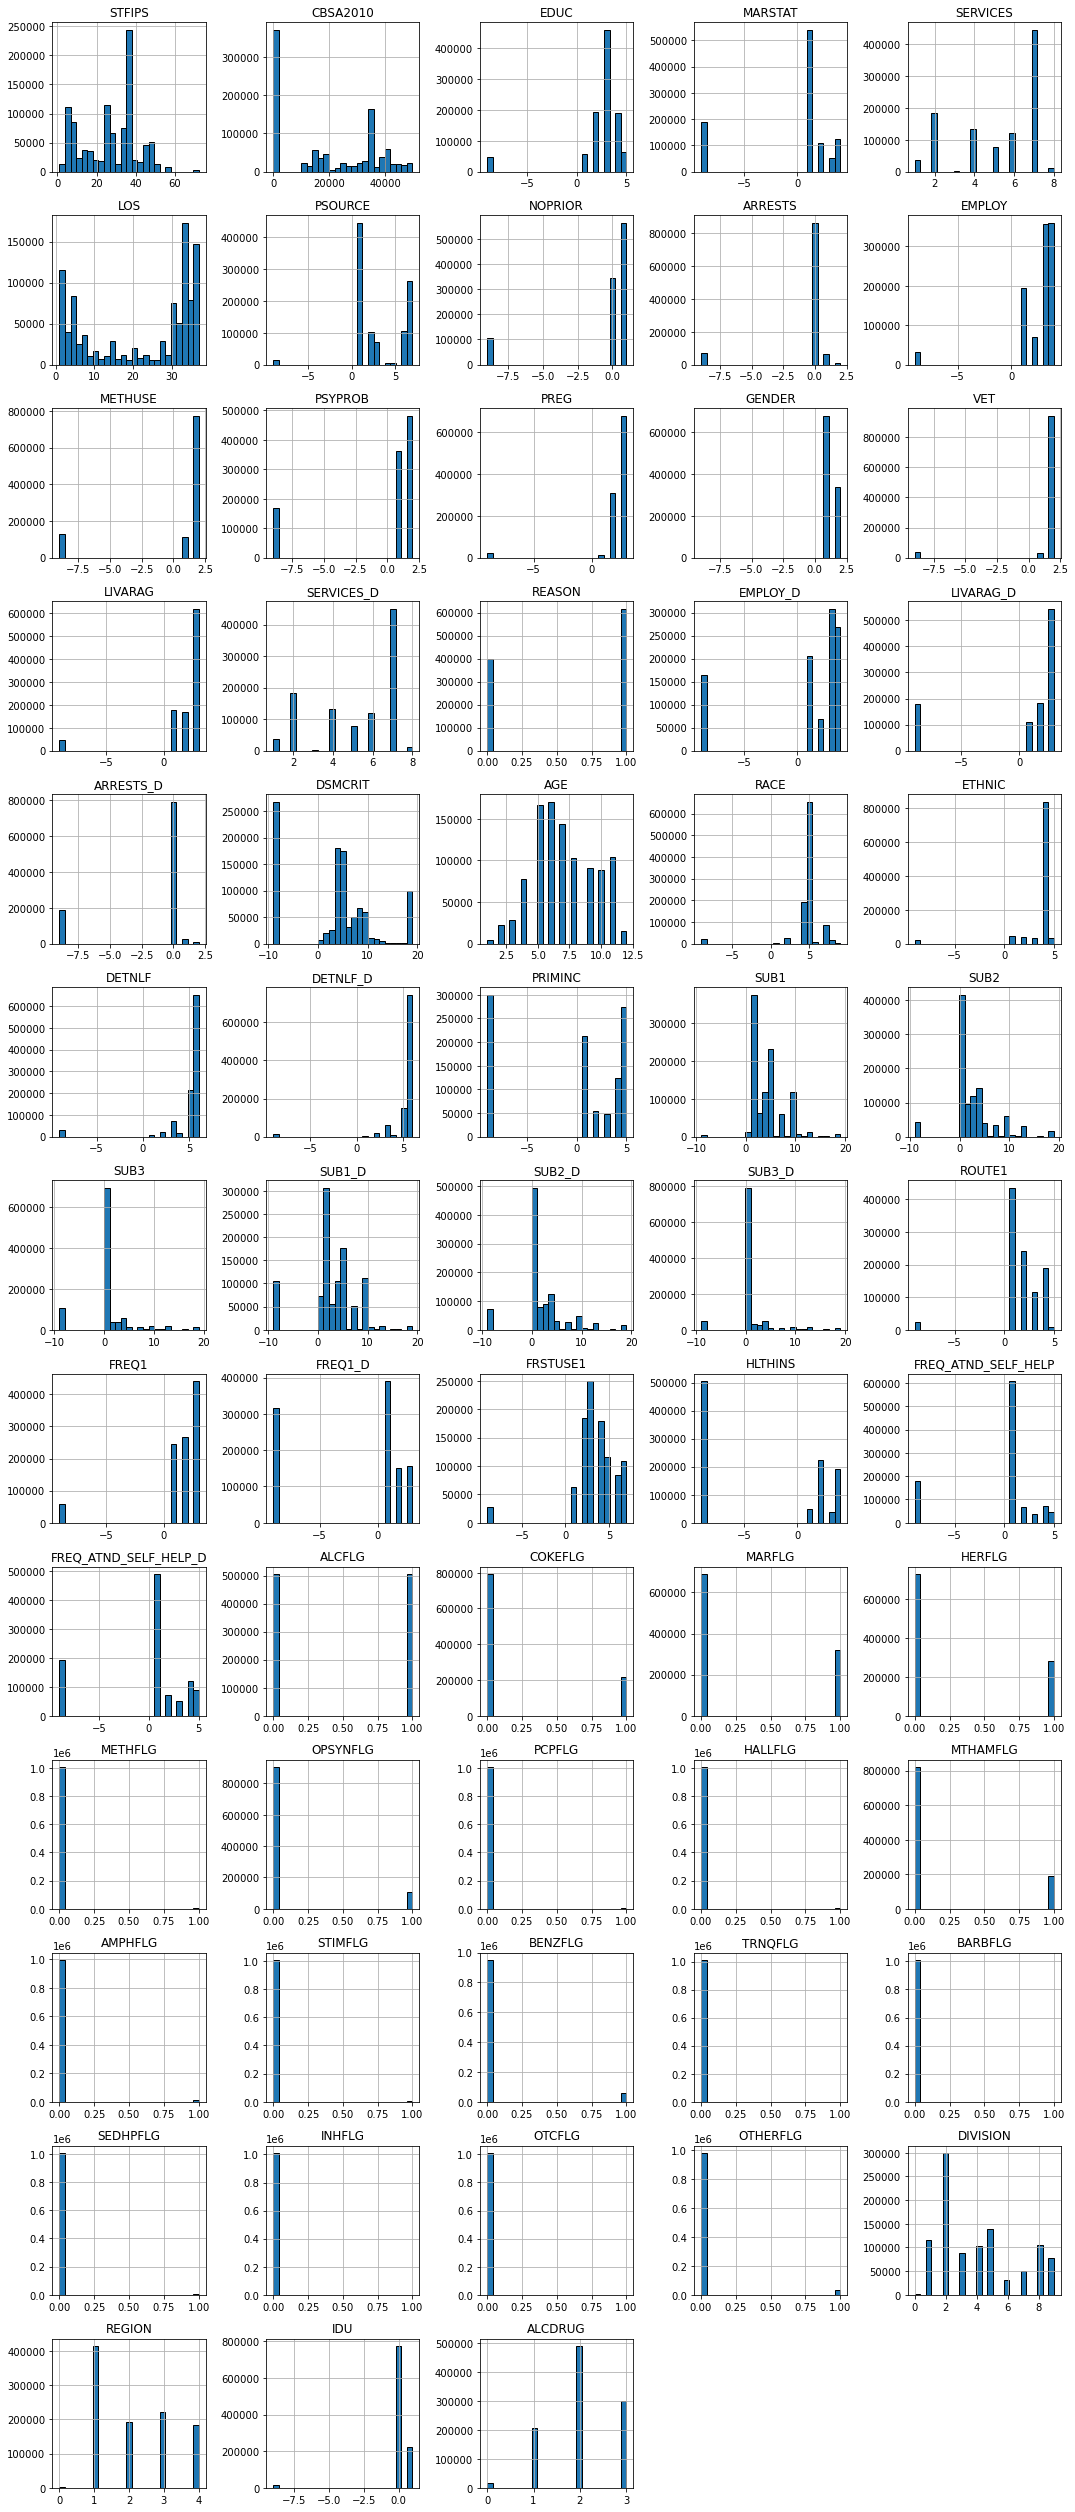

In [ ]:
#Plot histogram for each feature
print('Histogram for each feature')
df2.hist(bins=25, figsize=(15, 35), layout=(-1, 5), edgecolor="black")
plt.tight_layout()

In [ ]:
X = df2.drop('REASON', axis = 1)
X.shape

(1013707, 62)

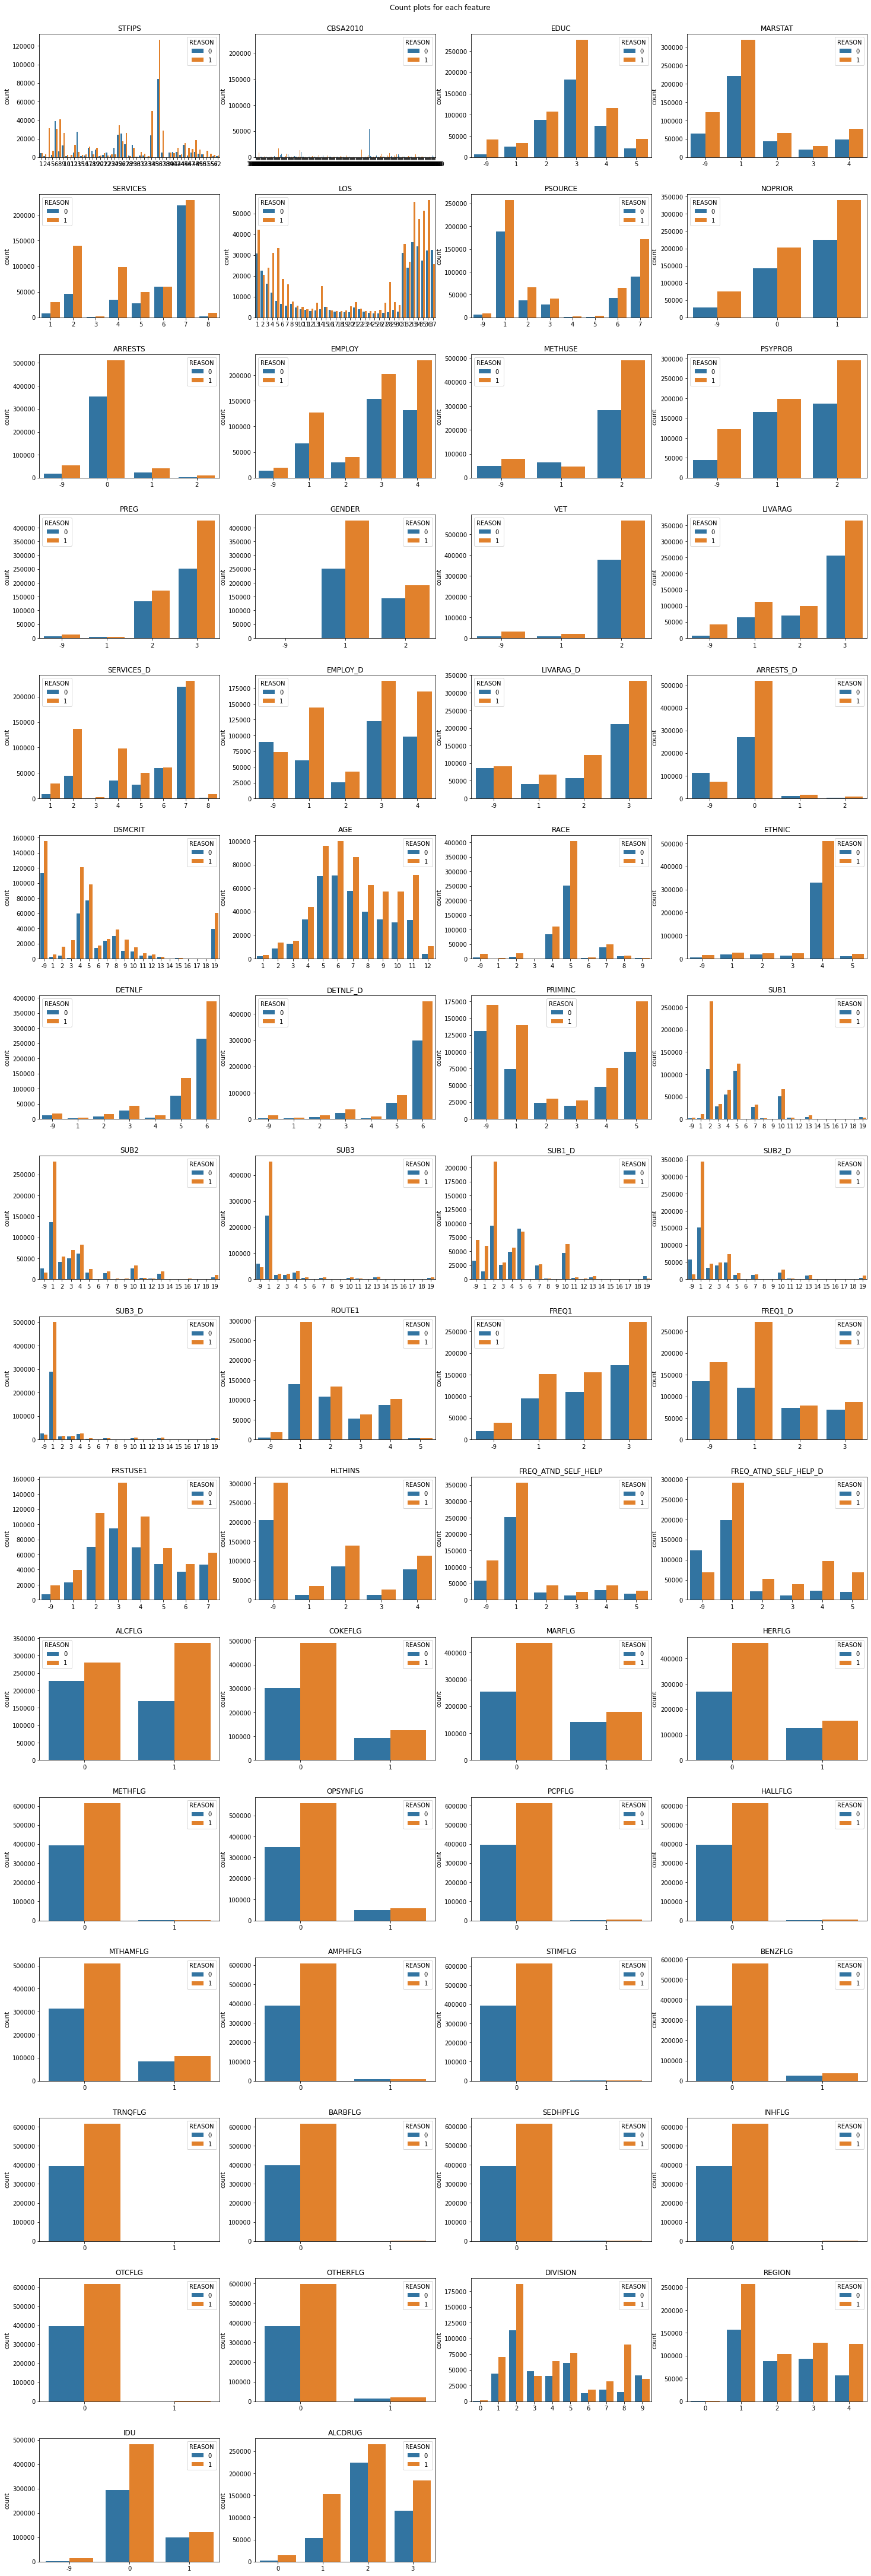

In [ ]:
#Plot distribution per feature separated by "REASON"
fig = plt.figure(figsize=(25, 70))
fig.tight_layout()
fig.subplots_adjust(top=0.97, hspace=0.3)
fig.suptitle("Count plots for each feature")

for n, col in enumerate(X.columns):
    # add a new subplot iteratively
    ax = plt.subplot(16, 4, n + 1)
    sns.countplot(x = df2[col], hue = "REASON", data = df2, ax=ax)
    ax.set_title(col.upper())
    ax.set_xlabel("")
plt.show()

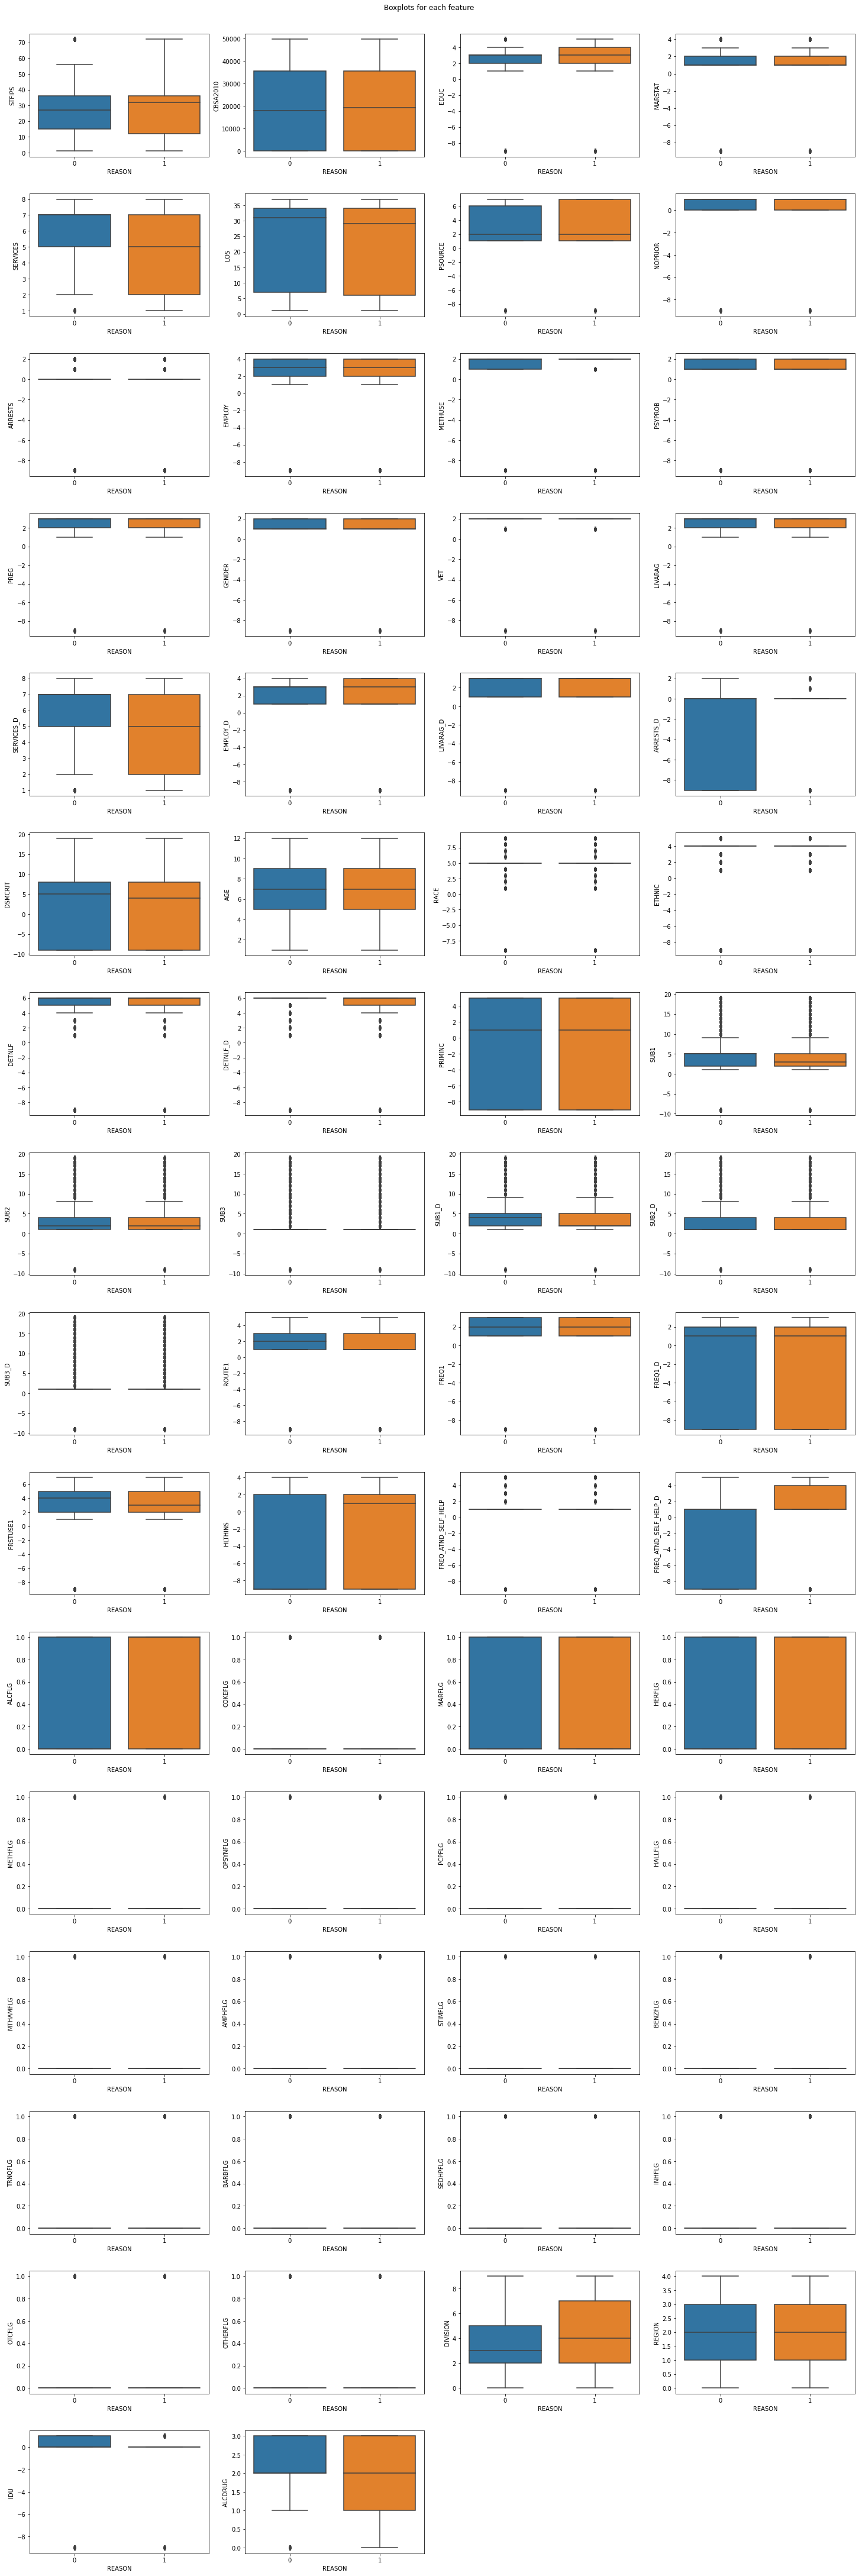

In [ ]:
#Boxplots per feature separated by "REASON"
fig = plt.figure(figsize=(25, 70))
fig.tight_layout()
fig.subplots_adjust(top=0.97, hspace=0.3)
fig.suptitle("Boxplots for each feature")

# loop through the length of tickers and keep track of index
for n, col in enumerate(X.columns):
    # add a new subplot iteratively
    ax = plt.subplot(16, 4, n + 1)
    sns.boxplot(data = df2, x = 'REASON', y = df2[col], ax = ax)
plt.show()